9/12/2020
## [ICWSM Revision]
Sloan/Reality Mining prediction -- within-network. ReFeX=RF, LINK=LogReg (unregularize), and node2vec (unregularize).

In [1]:
from __future__ import division
import os
import os
import itertools
from datetime import datetime, timedelta
from sklearn.model_selection import RandomizedSearchCV


folder_directory =os.getcwd()
os.chdir(folder_directory)
execfile('./functions/python_libraries.py')
execfile('./functions/parsing.py')  # Sam Way's Code
execfile('./functions/mixing.py')   # Sam Way's Code
execfile('./functions/create_adjacency_matrix.py')
execfile('./functions/LINK.py')


np.seterr(divide='ignore', invalid='ignore')

/Users/kristen/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [2]:
from __future__ import division
from sklearn.preprocessing import label_binarize
from sklearn import metrics
from sklearn.metrics import precision_recall_curve

#LINK-Logistic Regression [Zheleva, Getoor, 2009] uses labelled nodes to fit a regularized logistic regression model
#(Supplementary Note 2.2) that interprets rows of the adjacency matrix as sparse binary feature vectors,
#performing classification based on these features. The trained model is then applied to the feature vectors
#(adjacency matrix rows) of unlabelled nodes, which are scored based on the probability
# estimates from themodel.

def LINK(num_unlabeled, membership_y, feature_x, clf, num_iter, cv_setup=None):
    class_labels = np.sort(np.unique(np.array(membership_y))) #unique label IDs
    mean_accuracy = []
    se_accuracy = []
    mean_micro_auc = []
    se_micro_auc = []
    mean_wt_auc = []
    se_wt_auc = []
    mean_auc_under_pr_curve = []
    se_auc_under_pr_curve = []
    for i in range(len(num_unlabeled)):
        print(num_unlabeled[i])
        if cv_setup=='stratified':
            k_fold = cross_validation.StratifiedShuffleSplit((membership_y), n_iter=num_iter,
                                               test_size=num_unlabeled[i],
                                               random_state=0)
        else:
            k_fold = cross_validation.ShuffleSplit(len(membership_y), n_iter=num_iter,
                                                         test_size=num_unlabeled[i],
                                                         random_state=0)
        accuracy = []
        micro_auc = []
        wt_auc = []
        auc_under_pr_curve = []
        for k, (train, test) in enumerate(k_fold):
            #if k==0:
            #print train
            clf.fit(feature_x[train], np.ravel(membership_y[train]))
            pred = clf.predict(feature_x[test])
            prob = clf.predict_proba(feature_x[test])
            #accuracy.append(metrics.accuracy_score(membership_y[test], pred,  normalize = True))
            labeled_data = np.copy(np.array(membership_y))
            ground_truth_testing = np.array(labeled_data)[test]
            labeled_data[test]=np.max(class_labels)+1 # ignore testing labels -- don't have access as part of training -- want to assing test label outside of possible training labels
            
            accuracy_score_benchmark = np.mean(np.array(labeled_data)[train] == np.max(class_labels))

            # auc scores
            if len(np.unique(membership_y))>2:
                micro_auc.append(metrics.roc_auc_score(label_binarize(membership_y[test],np.unique(membership_y)), prob,  average = 'micro'))
                wt_auc.append(metrics.roc_auc_score(label_binarize(membership_y[test],np.unique(membership_y)), prob,
                                                                                                                             average = 'weighted'))
            else:
                micro_auc.append(metrics.roc_auc_score(label_binarize(membership_y[test],np.unique(membership_y)),
                                                                        prob[:,1],average='micro'))
                wt_auc.append(metrics.roc_auc_score(label_binarize(membership_y[test],np.unique(membership_y)),
                                                                            prob[:,1],average='weighted'))

                y_true = label_binarize(membership_y[test],np.unique(membership_y))
                y_pred = np.array(((prob[:,1]) >accuracy_score_benchmark)+0)
                accuracy.append(f1_score(y_true, y_pred, average='macro'))#, pos_label=1) )
                tn, fp, fn, tp = confusion_matrix(label_binarize(membership_y[test],np.unique(membership_y)),
                                                  ((prob[:,1]) >accuracy_score_benchmark)+0).ravel()
                precision, recall, thresholds = precision_recall_curve(
                        label_binarize(membership_y[test],np.unique(membership_y)), y_pred)
                auc_under_pr_curve.append(metrics.auc(recall, precision))
                    #accuracy.append((tn/(fp+tn)*0.5 + tp/(tp+fn))*0.5)

        mean_accuracy.append(np.mean(accuracy))
        se_accuracy.append(np.std(accuracy))
        mean_micro_auc.append(np.mean(micro_auc))
        se_micro_auc.append(np.std(micro_auc))
        mean_wt_auc.append(np.mean(wt_auc))
        se_wt_auc.append(np.std(wt_auc))
        
        mean_auc_under_pr_curve.append(np.mean(auc_under_pr_curve))
        se_auc_under_pr_curve.append(np.std(auc_under_pr_curve))
    return(mean_accuracy, se_accuracy, mean_micro_auc,se_micro_auc, mean_wt_auc,se_wt_auc, mean_auc_under_pr_curve,
          se_auc_under_pr_curve)


In [3]:
## set-up LINK to compare -- is this just an easy prediction problem?
edges = pd.read_csv('../../data/RealityMining/convert_bluetooth_nw/by_month/all_months_years.csv',
                   header = -1)
edges.head()
edges.drop(edges.columns[2], axis=1, inplace=True)
#nx.from_edgelist

In [4]:
#edges.head()
df = pd.crosstab(edges[0], edges[1])
idx = df.columns.union(df.index)
df = df.reindex(index = idx, columns=idx, fill_value=0)
#print np.sum(np.matrix(df),1)
print len(df)

93


In [5]:
G = nx.from_numpy_matrix(np.matrix(df))
nx.number_connected_components(G)

1

In [6]:
y = pd.read_csv('../../data/RealityMining/convert_bluetooth_nw/by_month/labels.csv')

class_type = 'sloan' # mlgrad sloan

if class_type =='sloan':
    y['y']=((y.affil_clean=='sloan') | (y.affil_clean=='sloan_2'))+0
if class_type == 'mlgrad':
    y['y']=((y.affil_clean=='mlgrad') | (y.affil_clean=='1styeargrad') | (y.affil_clean=='grad '))+0

  

In [7]:
y_labels = pd.DataFrame({'key':np.unique(np.concatenate((np.array(edges[0]),np.array(edges[1]))))})
y_labels = y_labels.merge(y[['id','y']],
              left_on = 'key',
              right_on = 'id',
              how = 'left')
np.array(y_labels.y)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0])

In [8]:
np.mean(y_labels.y)

0.27956989247311825

In [9]:
## break out by year -- exploration only
edges = pd.read_csv('../../data/RealityMining/convert_bluetooth_nw/by_month/10_2004.csv',
                   header = -1)
edges.head()
edges.drop(edges.columns[2], axis=1, inplace=True)
df = pd.crosstab(edges[0], edges[1])
idx = df.columns.union(df.index)
df = df.reindex(index = idx, columns=idx, fill_value=0)
G = nx.from_numpy_matrix(np.matrix(df))
y_labels = pd.DataFrame({'key':np.unique(np.concatenate((np.array(edges[0]),np.array(edges[1]))))})
y_labels = y_labels.merge(y[['id','y']],
              left_on = 'key',
              right_on = 'id',
              how = 'left')


In [10]:
np.sum(df,1).head()
degree = np.sum(df,1)
degree = pd.DataFrame(degree).reset_index()
degree.columns = ['key', 'degree']

In [11]:
edges_y = pd.read_csv('../../data/RealityMining/convert_bluetooth_nw/by_month/11_2004.csv',
                   header = -1)
edges_y.drop(edges_y.columns[2], axis=1, inplace=True)
df_y = pd.crosstab(edges_y[0], edges_y[1])
idx_y = df_y.columns.union(df_y.index)
df_y = df_y.reindex(index = idx_y, columns=idx_y, fill_value=0)

In [12]:
degree_y = np.sum(df_y,1)
degree_y = pd.DataFrame(degree_y).reset_index()
degree_y.columns = ['key', 'degree']

In [13]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [14]:
percent_initially_unlabelled = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05]
percent_initially_labelled = np.subtract(1, percent_initially_unlabelled)

In [39]:
percent_initially_labelled

array([0.1 , 0.2 , 0.3 , 0.4 , 0.5 , 0.6 , 0.7 , 0.8 , 0.9 , 0.95])

In [15]:
from sklearn.linear_model import LogisticRegressionCV


C_vals = [10**x for x in range(-10,100)]
model = linear_model.LogisticRegressionCV(
                                           Cs = C_vals,
                                           penalty='l2',
                                            solver='lbfgs',
                                           cv =2, max_iter = 1000)

In [16]:
import sklearn
sklearn.__version__
from sklearn import cross_validation, datasets, linear_model

n_iter = 25

/Users/kristen/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [17]:
np.shape(df)

(82, 82)

In [18]:
82*0.1

8.200000000000001

In [19]:
(mean_accuracy_LINK_RM, se_accuracy_LINK_RM, 
 mean_micro_auc_LINK_RM,se_micro_auc_LINK_RM, mean_wt_LINK_RM,se_wt_LINK_RM,
mean_auc_pr_curve, se_auc_pr_curve)= LINK(percent_initially_unlabelled, ## note: mean_se_model assumes a vector of x% initially labeled
                                                              np.array(y_labels.y), ## gender labels 
                                                              np.matrix(df), ## adjacency matrix
                                                             clf = model,
                                                            num_iter=n_iter, 
                                                            cv_setup = 'stratified')


0.9


/Users/kristen/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
0.05


In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))


In [21]:
mean_wt_LINK_RM

[0.9919137466307277,
 0.9974468085106384,
 0.9979166666666667,
 0.9978571428571429,
 0.9982445141065831,
 0.9988888888888888,
 0.9987301587301587,
 0.9986666666666667,
 1.0,
 1.0]

In [22]:
y = pd.read_csv('../../data/RealityMining/convert_bluetooth_nw/by_month/labels.csv')


if class_type =='sloan':
    y['y']=((y.affil_clean=='sloan') | (y.affil_clean=='sloan_2'))+0
if class_type == 'mlgrad':
    y['y']=((y.affil_clean=='mlgrad') | (y.affil_clean=='1styeargrad') | (y.affil_clean=='grad '))+0

    
x1= pd.read_csv('../../code/refex-rolx-master-1/RM-data/out_0.50_RealityMining_all_months_years.csv-featureValues.csv', header = -1)
x2= pd.read_csv('../../code/refex-rolx-master-2/RM-data/out_0.50_RealityMining_all_months_years.csv-featureValues.csv', header = -1)
x3= pd.read_csv('../../code/refex-rolx-master-3/RM-data/out_0.50_RealityMining_all_months_years.csv-featureValues.csv', header = -1)
xall= pd.read_csv('../../code/refex-rolx-master/RM-data/out_0.50_RealityMining_all_months_years.csv-featureValues.csv', header = -1)

#1x
df1 = pd.DataFrame({'id':np.array(map(np.int,x1[0]))})

y_label1 = df1.merge(y[['id','y']],
            how = 'left',
            on = 'id')
x1= x1.loc[:,1::]
scaler.fit(x1) #transform each feature on [0,1]-scale
x1 = scaler.transform(x1)


#2x
df2 = pd.DataFrame({'id':np.array(map(np.int,x2[0]))})

y_label2 = df2.merge(y[['id','y']],
            how = 'left',
            on = 'id')
x2= x2.loc[:,1::]
scaler.fit(x2) #transform each feature on [0,1]-scale
x2 = scaler.transform(x2)




#3x
df3 = pd.DataFrame({'id':np.array(map(np.int,x3[0]))})

y_label3 = df3.merge(y[['id','y']],
            how = 'left',
            on = 'id')
x3= x3.loc[:,1::]
scaler.fit(x3) #transform each feature on [0,1]-scale
x3 = scaler.transform(x3)



#all
dfall = pd.DataFrame({'id':np.array(map(np.int,xall[0]))})

y_labelall = dfall.merge(y[['id','y']],
            how = 'left',
            on = 'id')
xall= xall.loc[:,1::]
scaler.fit(xall) #transform each feature on [0,1]-scale
xall = scaler.transform(xall)


In [23]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV


In [24]:
from sklearn.linear_model import LogisticRegressionCV


C_vals = [10**x for x in range(-10,100)]
model1 = linear_model.LogisticRegressionCV(
                                           Cs = C_vals,
                                           penalty='l2',
                                            solver='lbfgs',
                                           cv = 2, max_iter = 1000)
model2 = linear_model.LogisticRegressionCV(
                                           Cs = C_vals,
                                           penalty='l2',
                                            solver='lbfgs',
                                           cv = 2, max_iter = 1000)

model3 = linear_model.LogisticRegressionCV(
                                           Cs = C_vals,
                                           penalty='l2',
                                            solver='lbfgs',
                                           cv = 2, max_iter = 1000)

modelall = linear_model.LogisticRegressionCV(
                                           Cs = C_vals,
                                           penalty='l2',
                                            solver='lbfgs',
                                           cv = 2, max_iter = 1000)


In [25]:
## node2vec
n2v_RM = pd.read_csv('../../code/node2vec/emb/RM.emb',
                      skiprows=1,
                    header = None,
                      sep=' ')
n2v_RM.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
0,100,0.136207,-0.085100,0.027711,-0.058467,-0.018517,0.090901,0.046466,0.026082,0.041344,...,0.107775,-0.035662,-0.087083,-0.029418,-0.118273,-0.067824,0.001471,0.095207,-0.163948,-0.223055
1,3,0.132249,-0.078536,0.022701,-0.050319,-0.018928,0.083171,0.043562,0.022488,0.036000,...,0.098503,-0.033239,-0.081079,-0.026492,-0.112709,-0.067217,0.006711,0.094674,-0.163911,-0.211333
2,7,0.136785,-0.080742,0.017946,-0.052969,-0.012840,0.089094,0.044227,0.027157,0.043876,...,0.101755,-0.037051,-0.082570,-0.028697,-0.108793,-0.065152,0.003769,0.093828,-0.157694,-0.212824
3,22,0.133923,-0.081681,0.022322,-0.054405,-0.013386,0.087281,0.040759,0.023713,0.041753,...,0.097982,-0.040126,-0.078636,-0.030004,-0.107275,-0.066228,-0.001584,0.096266,-0.155454,-0.212905
4,24,0.134223,-0.079952,0.019743,-0.048476,-0.012420,0.086209,0.038777,0.025724,0.039649,...,0.095069,-0.035510,-0.081300,-0.025945,-0.112942,-0.062278,0.005179,0.088536,-0.157139,-0.205110


In [26]:
tmp = pd.DataFrame(n2v_RM[0])
tmp.columns = ['keys']

y_labels = tmp.merge(y[['id','y']],
              left_on = 'keys',
              right_on = 'id',
              how = 'left')
np.sum(y_labels['keys']!=n2v_RM[0])

0

In [27]:
n2v_RM.drop(0, axis =1, inplace = True)

In [28]:
n2v_RM =n2v_RM[~np.isnan(y_labels.y)]
y_labels =y_labels[~np.isnan(y_labels.y)]
n_iter = 25


In [29]:
np.shape(x1)

(93, 5)

In [30]:
np.shape(x1)

(93, 5)

In [31]:
np.shape(y_labels)

(93, 3)

In [32]:
(mean_accuracy_x1, se_accuracy_x1, 
 mean_micro_auc_x1,se_micro_auc_x1, mean_wt_auc_x1_lbfgs,se_wt_auc_x1,
mean_pr_auc, se_pr_auc)= LINK(percent_initially_unlabelled, ## note: mean_se_model assumes a vector of x% initially labeled
                                                              np.array(y_label1.y), ## gender labels 
                                                              np.matrix(x1), ## adjacency matrix
                                                              clf = model1,
                              num_iter=n_iter,
                              cv_setup = 'stratified')

0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
0.05


In [33]:
mean_wt_auc_x1_lbfgs

[0.691176051318603,
 0.764973544973545,
 0.7527083333333334,
 0.8025937499999999,
 0.7921719457013574,
 0.7585858585858586,
 0.783875,
 0.7685714285714286,
 0.7333333333333333,
 0.735]

In [34]:
(mean_accuracy_x2, se_accuracy_x2, 
 mean_micro_auc_x2,se_micro_auc_x2, mean_wt_auc_x2_lbfgs,se_wt_auc_x2,
mean_pr_auc, se_pr_auc)= LINK(percent_initially_unlabelled, ## note: mean_se_model assumes a vector of x% initially labeled
                                                              np.array(y_label2.y), ## gender labels 
                                                              np.matrix(x2), ## adjacency matrix
                                                              clf = model2,num_iter=n_iter, cv_setup = 'stratified')

0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
0.05


In [35]:
(mean_accuracy_x3, se_accuracy_x3, 
 mean_micro_auc_x3,se_micro_auc_x3, mean_wt_auc_x3_lbfgs,se_wt_auc_x3,
mean_pr_auc, se_pr_auc)= LINK(percent_initially_unlabelled, ## note: mean_se_model assumes a vector of x% initially labeled
                                                              np.array(y_label3.y), ## gender labels 
                                                              np.matrix(x3), ## adjacency matrix
                                                              clf = model3,num_iter=n_iter, cv_setup = 'stratified')

0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
0.05


In [36]:
(mean_accuracy_xall, se_accuracy_xall, 
 mean_micro_auc_xall,se_micro_auc_xall, mean_wt_auc_xall_lbfgs,se_wt_auc_xall,
mean_pr_auc, se_pr_auc)= LINK(percent_initially_unlabelled, ## note: mean_se_model assumes a vector of x% initially labeled
                                                              np.array(y_labelall.y), ## gender labels 
                                                              np.matrix(xall), ## adjacency matrix
                                                              clf = modelall,num_iter=n_iter, cv_setup = 'stratified')

0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
0.05


In [37]:
df_results = pd.DataFrame({'mean_wt_auc_x1_lbfgs': mean_wt_auc_x1_lbfgs,
                            'se_wt_auc_x1': se_wt_auc_x1,
                            'mean_wt_auc_x2_lbfgs': mean_wt_auc_x2_lbfgs,
                            'se_wt_auc_x2': se_wt_auc_x2,
                            'mean_wt_auc_x3_lbfgs': mean_wt_auc_x3_lbfgs,
                            'se_wt_auc_x3': se_wt_auc_x3,
                            'mean_wt_auc_xall_lbfgs': mean_wt_auc_xall_lbfgs,
                            'se_wt_auc_xall': se_wt_auc_xall,
                           'mean_wt_LINK_RM':mean_wt_LINK_RM,
                           'se_wt_LINK_RM': se_wt_LINK_RM,
                           #'mean_wt_node2vec':mean_wt_node2vec_C_LRCV,
                           #'se_wt_node2vec':se_wt_node2vec_LRCV
                            })
df_results.to_csv('NEWRMesultsICWSMRevision.csv',sep=',', index = False)

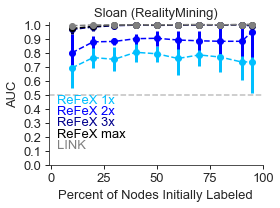

In [38]:
from matplotlib.backends.backend_pdf import PdfPages

alpha_empirical = 0.4

%matplotlib inline
nbins = 45
f, (ax1) = plt.subplots(1, 1, 
                    sharey=False, sharex=False,
                figsize=(4,3))

plt.setp(ax1, xticks=[0,25,50,75,100])


ax1.set_xticks([0,25,50,75,100])
ax1.minorticks_on()
ax1.tick_params('both', length=4, width=1, which='major', left=1, bottom=1, top=0, right=0, labelsize = 13)

w = 1.5
width = 0.15
ax1.errorbar(percent_initially_labelled*100, df_results.mean_wt_auc_x1_lbfgs,
            yerr=df_results.se_wt_auc_x1, fmt='--o', capthick=2,
            alpha=1, elinewidth=3, color='deepskyblue')

ax1.errorbar(percent_initially_labelled*100, df_results.mean_wt_auc_x2_lbfgs,
    yerr=df_results.se_wt_auc_x2, fmt='--o', capthick=2,
    alpha=1, elinewidth=3, color='blue')
ax1.errorbar(percent_initially_labelled*100, df_results.mean_wt_auc_x3_lbfgs,
    yerr=df_results.se_wt_auc_x3, fmt='--o', capthick=2,
    alpha=1, elinewidth=3, color='darkblue')
ax1.errorbar(percent_initially_labelled*100, df_results.mean_wt_auc_xall_lbfgs,
    yerr=df_results.se_wt_auc_xall, fmt='--o', capthick=2,
    alpha=1, elinewidth=3, color='black')
ax1.errorbar(percent_initially_labelled*100, df_results.mean_wt_LINK_RM,
    yerr=df_results.se_wt_LINK_RM, fmt='--o', capthick=2,
    alpha=1, elinewidth=3, color='gray')

#ax1.errorbar(percent_initially_labelled*100, df_results.mean_wt_node2vec,
#    yerr=df_results.se_wt_node2vec, fmt='--o', capthick=2,
#    alpha=1, elinewidth=3, color='red')



ax1.annotate('ReFeX 1x', xy=(3, 0.44), 
         color='deepskyblue', alpha=1, size=13)
ax1.annotate('ReFeX 2x', xy=(3, 0.36), 
         color='blue', alpha=1, size=13)
ax1.annotate('ReFeX 3x', xy=(3, 0.28), 
         color='darkblue', alpha=1, size=13)
ax1.annotate('ReFeX max', xy=(3, 0.2), 
         color='black', alpha=1, size=13)
ax1.annotate('LINK', xy=(3, 0.12), 
         color='gray', alpha=1, size=13)
#ax1.annotate('node2vec', xy=(3, 0.15), 
#         color='red', alpha=1, size=10)


## UPDATE HERE
#ax.set_xticklabels(x_ticks, rotation=0, fontsize=8)
#ax.set_yticklabels(y_ticks, rotation=0, fontsize=8)


ax1.set_ylabel('AUC', size=13)
ax1.set_xlabel('Percent of Nodes Initially Labeled', size=13)


#ax1.set_xlim(-1,np.max(np.array(range(len(acc_generic)))*w)+1)
ax1.set_ylim(0,1.02)
plt.yticks(np.arange(0,1.02,0.1))
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.set_xlim(-1,100)
plt.axhline(0.5, color='gray', linestyle='--', alpha = 0.5)

plt.title('Sloan (RealityMining)',fontsize=13)
plt.tight_layout()
#plt.show()

#figs-ICWSM-revision